In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

# Explainability
import joblib

df = pd.read_csv('ai4i2020.csv')
df.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
print(df.info())
print(df.isnull().sum())           # No missing values confirmed
print(df['Machine failure'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

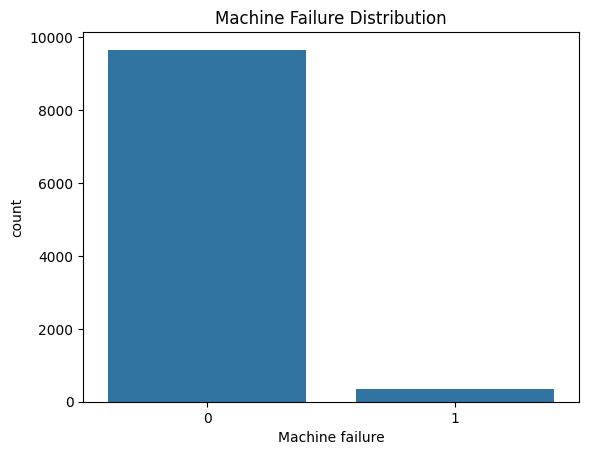

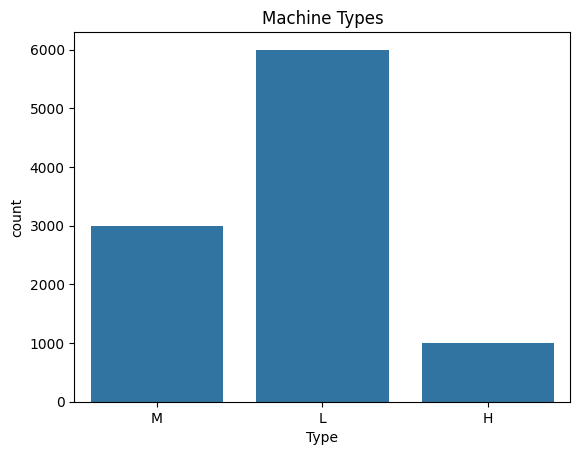

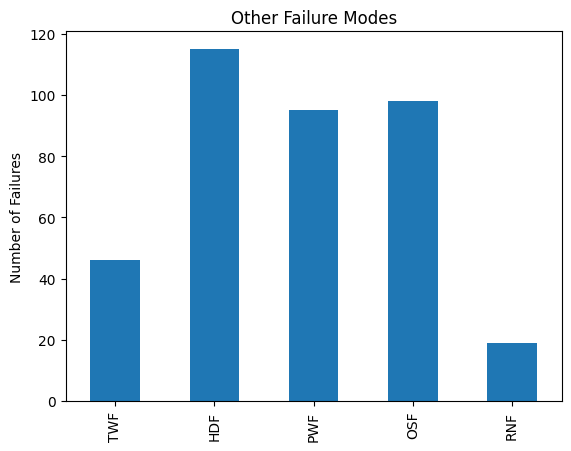

In [4]:
# Target distribution
sns.countplot(x='Machine failure', data=df)
plt.title('Machine Failure Distribution')
plt.show()

# Distribution of machine types
sns.countplot(x='Type', data=df)
plt.title('Machine Types')
plt.show()

# Visualize failure modes (TWF/HDF/...)
failure_modes = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df[failure_modes].sum().plot(kind='bar')
plt.title('Other Failure Modes')
plt.ylabel("Number of Failures")
plt.show()


In [5]:
# Drop identifiers
df = df.drop(['UDI', 'Product ID'], axis=1, errors='ignore')

# Encode type: L, M, H -> 0, 1, 2
df['Type'] = LabelEncoder().fit_transform(df['Type'])

# Features to model
feature_cols = ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
target_col = 'Machine failure'

X = df[feature_cols]
y = df[target_col]


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [7]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)


C:\Users\achya\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:22:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Accuracy: 0.989
ROC-AUC: 0.9639127390086469
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.91      0.75      0.82        68

    accuracy                           0.99      2000
   macro avg       0.95      0.87      0.91      2000
weighted avg       0.99      0.99      0.99      2000



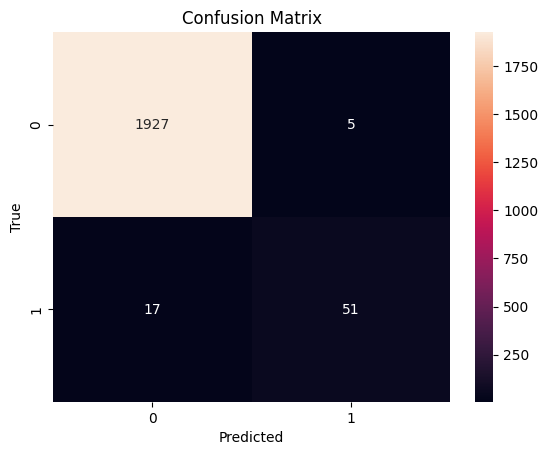

In [8]:
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


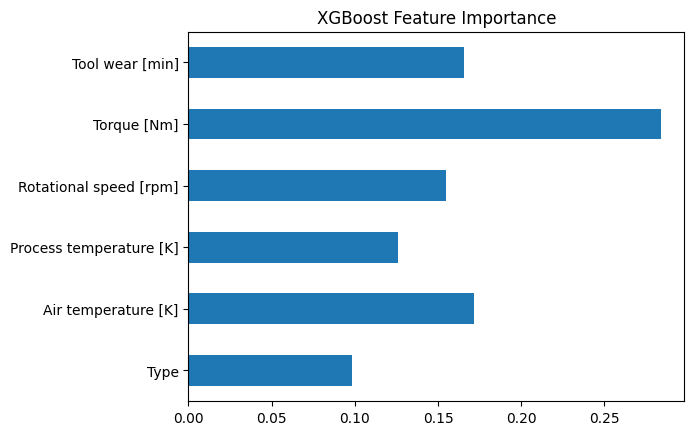

In [9]:
fi = pd.Series(xgb.feature_importances_, index=feature_cols)
fi.plot(kind='barh', title='XGBoost Feature Importance')
plt.show()


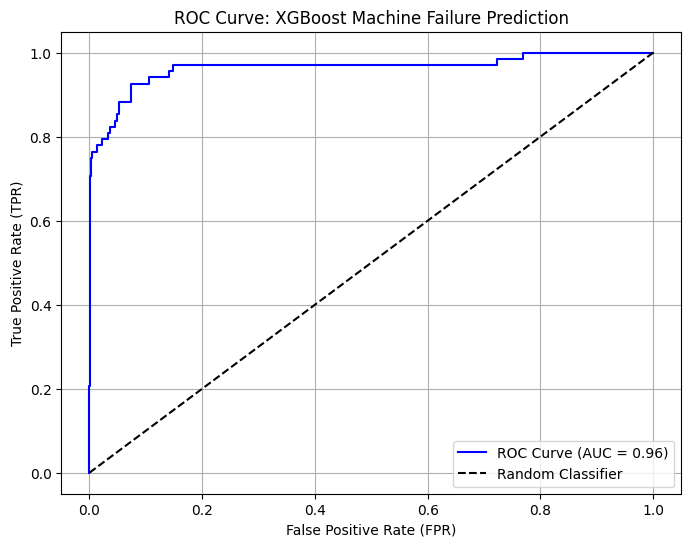

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# y_test = true labels, y_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve: XGBoost Machine Failure Prediction')
plt.legend()
plt.grid(True)
plt.show()


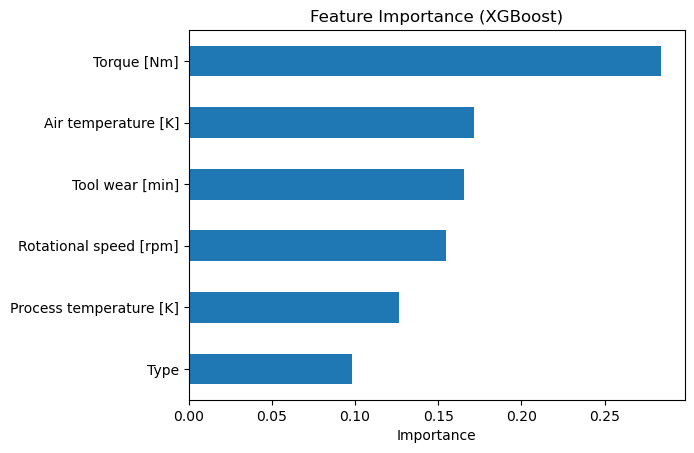

In [11]:
fi = pd.Series(xgb.feature_importances_, index=feature_cols)
fi.sort_values().plot(kind='barh', title='Feature Importance (XGBoost)')
plt.xlabel('Importance')
plt.show()

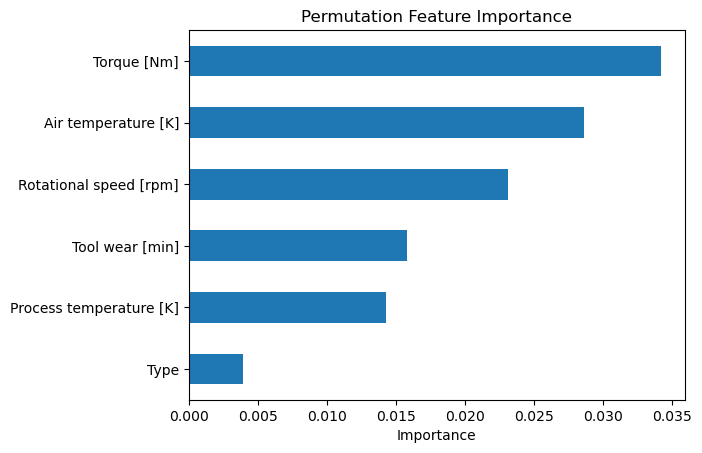

In [12]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(xgb, X_test, y_test, random_state=42)
fi_perm = pd.Series(perm_importance.importances_mean, index=feature_cols)
fi_perm.sort_values().plot(kind='barh', title='Permutation Feature Importance')
plt.xlabel('Importance')
plt.show()


In [14]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgb, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_cols)


Weight,Feature
0.0345 ± 0.0030,Torque [Nm]
0.0300 ± 0.0058,Air temperature [K]
0.0238 ± 0.0049,Rotational speed [rpm]
0.0149 ± 0.0048,Process temperature [K]
0.0137 ± 0.0035,Tool wear [min]
0.0038 ± 0.0031,Type


In [16]:
i = 888 # index of the test sample to explain
eli5.show_prediction(xgb, X_test[i], feature_names=feature_cols)


In [17]:
import joblib
import json

# Save your XGBoost model
joblib.dump(xgb, "xgb_model.joblib")

# Save scaler (if used, e.g., StandardScaler or MinMaxScaler)
try:
    joblib.dump(scaler, "scaler.joblib")
    print("Scaler saved.")
except NameError:
    print("No scaler defined - skipping.")

# Save label encoder for 'Type' (if applicable)
try:
    joblib.dump(type_encoder, "type_encoder.joblib")
    print("Type encoder saved.")
except NameError:
    print("No type encoder defined/saved.")

# Save your feature columns
with open("feature_cols.json", "w") as f:
    json.dump(feature_cols, f)

print("Model, scaler & features saved for deployment!")


Scaler saved.
No type encoder defined/saved.
Model, scaler & features saved for deployment!


In [18]:
from eli5.sklearn import PermutationImportance
import joblib

perm = PermutationImportance(xgb, random_state=42).fit(X_test, y_test)
importances = perm.feature_importances_  # or perm.importances_mean
joblib.dump(importances, "perm_importances.joblib")
joblib.dump(feature_cols, "feature_cols.joblib")


['feature_cols.joblib']